### Plot Prediction Result to a Heatmap

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [24]:
from utils.plot_utils import generate_prediction_mask, generate_original_mask
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
IMG_ID = '078'

In [21]:
slide_img, truth_mask_img = generate_original_mask(IMG_ID)
_, pred_mask_img = generate_prediction_mask('dummy', IMG_ID)

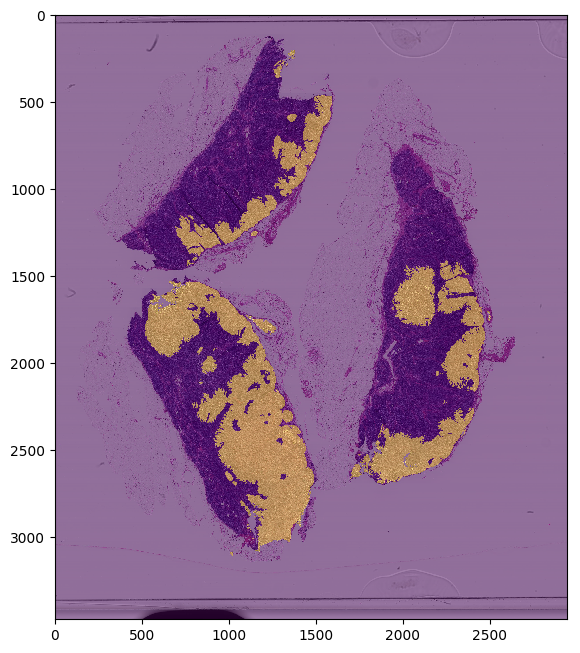

In [25]:
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_img,)
plt.imshow(truth_mask_img, alpha=0.5)

Text(0.5, 1.0, 'Slide 078 Prediction Heatmap')

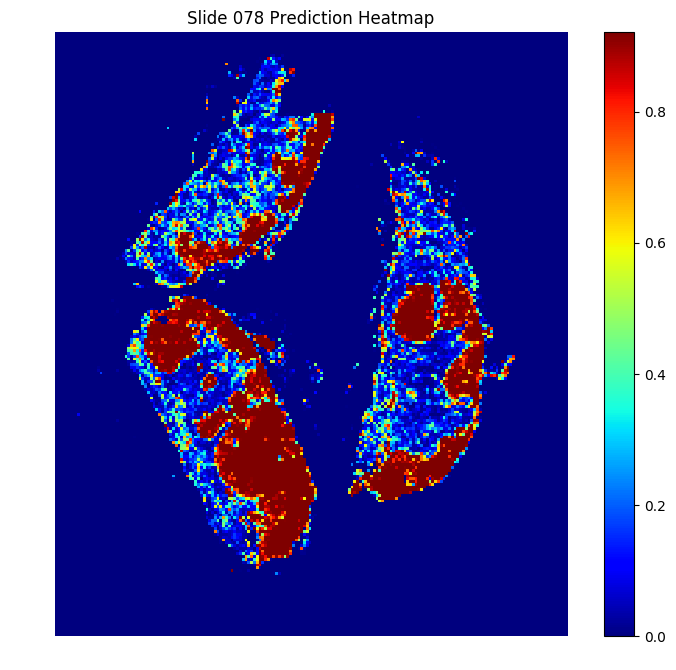

In [27]:
plt.figure(figsize=(8,8), dpi=100)
# plt.imshow(pred_mask, cmap='jet', interpolation='nearest')
plt.imshow(pred_mask_img, cmap='jet', interpolation='nearest')
# plt.imshow(mask_img, cmap='jet', alpha=0.5)
plt.colorbar(fraction=0.053, pad=0.06)
plt.axis('off')
plt.title('Slide {} Prediction Heatmap'.format(IMG_ID))

In [ ]:
from common.utils.image_preprocess import read_slide

In [ ]:
import os
from openslide import open_slide
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
from tqdm import tqdm
import cv2

In [ ]:
SOURCE_IMG_DATA_DIR = '/Users/seung-jae_bang/Personal/Columbia/Applied_DL/Camelyon_Project/data/source_data/'
SAMPLE_PRED_DATA_DIR = '/Users/seung-jae_bang/Personal/Columbia/Applied_DL/Camelyon_Project/data/saved_model_outputs/vgg_transfer_learn_zoom1_256_256/inference'

ZOOM_LEVEL = 5

In [67]:
SAMPLE_IMG = '078'

In [68]:
source_slide_img_file_name = 'tumor_{}.tif'.format(SAMPLE_IMG)
source_mask_img_file_name = 'tumor_{}_mask.tif'.format(SAMPLE_IMG)

In [69]:
slide = open_slide(os.path.join(SOURCE_IMG_DATA_DIR, source_slide_img_file_name))
mask = open_slide(os.path.join(SOURCE_IMG_DATA_DIR, source_mask_img_file_name))

In [70]:
slide.level_dimensions

((94208, 111104),
 (47104, 55552),
 (23552, 27776),
 (11776, 13888),
 (5888, 6944),
 (2944, 3472),
 (1472, 1736),
 (736, 868),
 (368, 434))

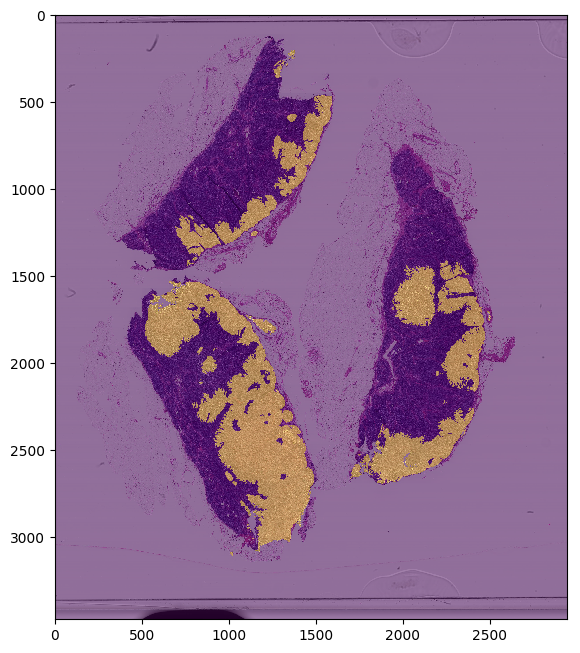

In [71]:
slide_img = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_img = read_slide(mask,
                      x=0,
                      y=0,
                      level=5,
                      width=mask.level_dimensions[5][0],
                      height=mask.level_dimensions[5][1])[:, :, 0]

plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_img,)
plt.imshow(mask_img, alpha=0.5)

In [72]:
mask_img.shape

(3472, 2944)

#### Post Process Prediction Mask

In [73]:
def get_row_col_id_from_file_name(file_name, component_idxes):
    components = file_name.split('.')[0].split('_')
    return (components[component_idxes[0]], components[component_idxes[1]])

def get_row_col_ids_from_file_name_list(file_name_list, component_idxes=(4, 5)):
    temp = [get_row_col_id_from_file_name(f, component_idxes=component_idxes) for f in file_name_list]
    
    row_ids, col_ids = list(zip(*temp))
    row_ids = np.sort(np.unique(row_ids).astype(int))
    col_ids = np.sort(np.unique(col_ids).astype(int))
    
    return (row_ids, col_ids)

In [74]:
def get_mask_range_for_pred(pred_row_id, pred_col_id, pred_width, pred_height, zoom_factor):
    
    x_start = int((pred_row_id * pred_height) / zoom_factor)
    x_end = int(((pred_row_id + 1) * pred_height) / zoom_factor)
    
    y_start = int((pred_col_id * pred_width) / zoom_factor)
    y_end = int(((pred_col_id + 1) * pred_width) / zoom_factor)
    
    return x_start, x_end, y_start, y_end

In [75]:
inference_file_name = 'zoom_1_256_256_test_inference_result.pkl'

In [76]:
inference_df = pd.read_pickle(os.path.join(SAMPLE_PRED_DATA_DIR, inference_file_name))

In [77]:
inference_df.head()

,file_name,img_id,include,label,non_gray_ratio,type,is_roi,y_pred_prob
100000,tumor_slide_002_split_67_138.png,002,0,0,0.000000,test,0,0.009275
100001,tumor_slide_002_split_272_51.png,002,0,0,0.000000,test,0,0.009275
100002,tumor_slide_002_split_125_13.png,002,0,0,0.000000,test,0,0.008561
100003,tumor_slide_002_split_223_9.png,002,0,0,0.000000,test,0,0.008327
100004,tumor_slide_002_split_230_156.png,002,0,0,0.034546,test,0,0.002517


In [78]:
inference_df.loc[inference_df['is_roi'] == 0, 'y_pred_prob'] = 0

In [79]:
inference_df['img_id'].unique()

array(['002', '057', '078', '091'], dtype=object)

In [80]:
inference_df.shape

(216788, 8)

In [81]:
pred_mask = np.zeros_like(mask_img).astype(float)

In [82]:
pred_mask.sum()

0.0

In [83]:
downsample_factors = mask.level_downsamples

In [84]:
factor_ratio = downsample_factors[5] / downsample_factors[1]

In [85]:
factor_ratio

16.0

In [86]:
inference_df_for_img = inference_df[inference_df['img_id'] == SAMPLE_IMG]

In [87]:
for idx, row in inference_df_for_img.iterrows():
    pred_row_id, pred_col_id = get_row_col_id_from_file_name(row['file_name'],
                                                             component_idxes=(4, 5))
    pred_row_id, pred_col_id = int(pred_row_id), int(pred_col_id)
    x_start, x_end, y_start, y_end = get_mask_range_for_pred(pred_row_id, 
                                                             pred_col_id, 
                                                             256, 
                                                             256, 
                                                             16)
    pred_mask[x_start:x_end, y_start:y_end] = row['y_pred_prob']

In [88]:
pred_mask.sum()

1354784.2376403809

In [89]:
inference_df_for_img['y_pred_prob'].sum() * 256

1354784.25

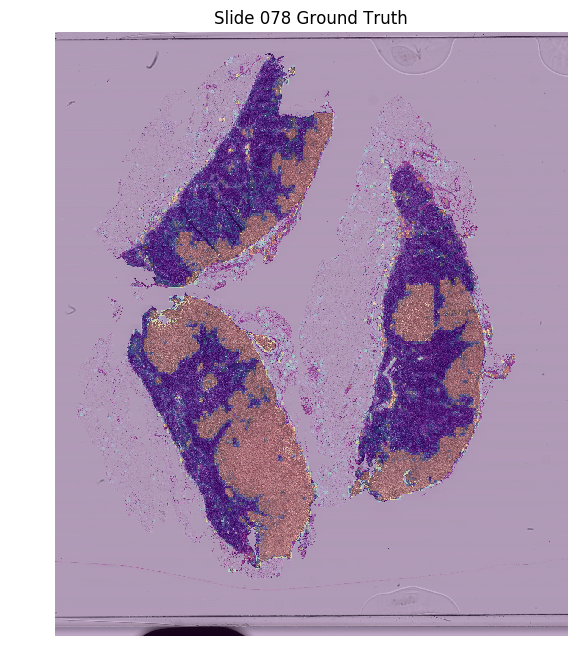

In [110]:
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(slide_img)
plt.imshow(pred_mask, alpha=0.3)
plt.axis('off')
plt.title('Slide {} Ground Truth'.format(SAMPLE_IMG))

plt.savefig('slide_{}_ground_truth.jpg'.format(SAMPLE_IMG))

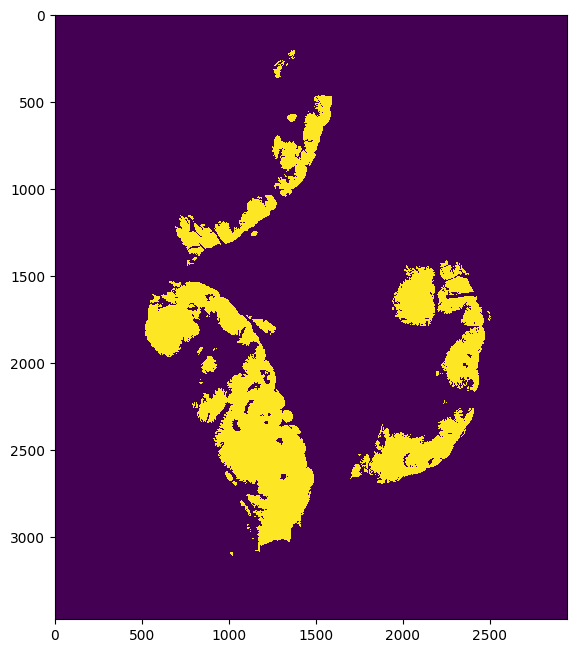

In [91]:
plt.figure(figsize=(8,8), dpi=100)
plt.imshow(mask_img)

In [98]:
blurred_pred_mask = cv2.blur(pred_mask, (7, 7))
# blurred_pred_mask = cv2.GaussianBlur(pred_mask,(7,7), 7)

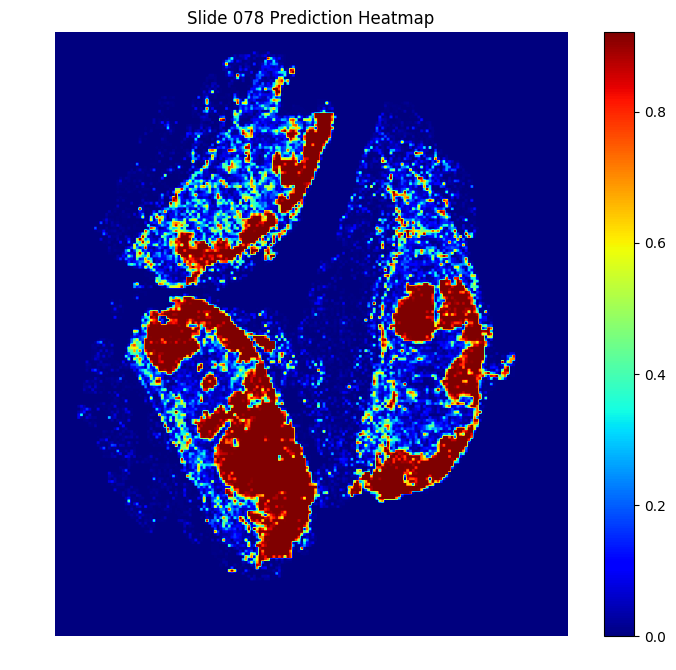

In [111]:
plt.figure(figsize=(8,8), dpi=100)
# plt.imshow(pred_mask, cmap='jet', interpolation='nearest')
plt.imshow(blurred_pred_mask, cmap='jet', interpolation='nearest')
# plt.imshow(mask_img, cmap='jet', alpha=0.5)
plt.colorbar(fraction=0.053, pad=0.06)
plt.axis('off')
plt.title('Slide {} Prediction Heatmap'.format(SAMPLE_IMG))
plt.savefig('slide_{}_prediction_heatmap.jpg'.format(SAMPLE_IMG))

In [100]:
# plt.imshow(heat_map, cmap='jet', interpolation='nearest')
#             plt.colorbar()
#             plt.clim(0.00, 1.00)
#             plt.axis([0, heatmap_rgb.shape[1], 0, heatmap_rgb.shape[0]])
#             plt.savefig(heatmap_filename)
#             plt.clf()